# Overview of the project

###The Makridakis Open Forecasting Center (MOFC) at the University of Nicosia conducts cutting-edge forecasting research and provides business forecast training. It helps companies achieve accurate predictions, estimate the levels of uncertainty, avoiding costly mistakes, and apply best forecasting practices. The MOFC is well known for its Makridakis Competitions, the first of which ran in the 1980s.



## Aim of the project:

###This data is  hierarchical sales data from Walmart, the world’s largest company by revenue, and the aim of this project is  to forecast daily sales for the next 28 days and to make uncertainty estimates for these forecasts. 

###The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. Together, this robust dataset can be used to improve forecasting accuracy.


## Description of the data provided

###calendar.csv - Contains information about the dates on which the products are sold.
###sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
###sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.
###sell_prices.csv - Contains information about the price of the products sold per store and date.
###sales_train_evaluation.csv - Includes sales [d_1 - d_1941] 

## Importing the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

import warnings
warnings.filterwarnings("ignore")


In [ ]:
import matplotlib.pyplot as plt

import time
import math
import datetime


# Import widgets
from ipywidgets import widgets, interactive, interact
import ipywidgets as widgets
from IPython.display import display

from math import log, floor
from sklearn.neighbors import KDTree

import seaborn as sns
sns.set_style('whitegrid')

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

import itertools
from itertools import cycle
plt.style.use('seaborn')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

## Data Importation

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
 # helper functions to reduce memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']     
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train_df = reduce_mem_usage(train_df)

Mem. usage decreased to 96.13 Mb (78.8% reduction)


In [ ]:
# Helper functions
def plot_time_series(data, ax=None, show=False):
    """Plot time series data."""
    if ax is None:
        fig, ax = plt.subplots()
    for ind in data.index:
        ax.plot([int(col.split('_')[-1]) for col in data.columns], 
                data.loc[ind].values, '-', label=ind)
    ax.legend(loc='best')
    ax.set_xlabel('day number')
    ax.set_ylabel('items sold')
    if show:
        plt.show(block=False)

def plot_aggregation(data):
    """Make plots over two time periods."""
    plot_time_series(data)
    plot_time_series(data[data.columns[-3*28:]])

In [ ]:
train_df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938',
       'd_1939', 'd_1940', 'd_1941'],
      dtype='object', length=1947)

In [ ]:
train_df=train_df.fillna(0)

In [ ]:
# Get column groups
categorical_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
ts_cols = [col for col in train_df.columns if col not in categorical_cols]
print(ts_cols)
ts_dict = {t: int(t[2:]) for t in ts_cols[1:]}

# Describe data
print('  unique forecasts: %i' % len(train_df.id.unique()))
for col in categorical_cols:
    print('   N_unique %s: %i' % (col, train_df[col].nunique()))

['id', 'd_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10', 'd_11', 'd_12', 'd_13', 'd_14', 'd_15', 'd_16', 'd_17', 'd_18', 'd_19', 'd_20', 'd_21', 'd_22', 'd_23', 'd_24', 'd_25', 'd_26', 'd_27', 'd_28', 'd_29', 'd_30', 'd_31', 'd_32', 'd_33', 'd_34', 'd_35', 'd_36', 'd_37', 'd_38', 'd_39', 'd_40', 'd_41', 'd_42', 'd_43', 'd_44', 'd_45', 'd_46', 'd_47', 'd_48', 'd_49', 'd_50', 'd_51', 'd_52', 'd_53', 'd_54', 'd_55', 'd_56', 'd_57', 'd_58', 'd_59', 'd_60', 'd_61', 'd_62', 'd_63', 'd_64', 'd_65', 'd_66', 'd_67', 'd_68', 'd_69', 'd_70', 'd_71', 'd_72', 'd_73', 'd_74', 'd_75', 'd_76', 'd_77', 'd_78', 'd_79', 'd_80', 'd_81', 'd_82', 'd_83', 'd_84', 'd_85', 'd_86', 'd_87', 'd_88', 'd_89', 'd_90', 'd_91', 'd_92', 'd_93', 'd_94', 'd_95', 'd_96', 'd_97', 'd_98', 'd_99', 'd_100', 'd_101', 'd_102', 'd_103', 'd_104', 'd_105', 'd_106', 'd_107', 'd_108', 'd_109', 'd_110', 'd_111', 'd_112', 'd_113', 'd_114', 'd_115', 'd_116', 'd_117', 'd_118', 'd_119', 'd_120', 'd_121', 'd_122', 'd_

## Let us take a subset of the data

Under this section we will seek to:

1) Create new features and find their relationship with the sales

2) Remove redundant(useless) features

3) Remove outliers where necessary

4) Deal with Nan Values

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB


In [ ]:
len(train_df)

30490

In [ ]:
train_df_sub = train_df.loc[:2000,:]

In [ ]:
prices_df_sub = prices_df.loc[:2000, :]

In [ ]:
#merging the DataFrame
def merge_by_concat(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = pd.DataFrame(merged_gf).merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    return df1



In [ ]:
TARGET = 'sales'         # Our main target
END_TRAIN = 1913         # Last day in train set
MAIN_INDEX = ['id','d']

In [ ]:
########################### Make Grid
#################################################################################
print('Create Grid')

# We can tranform horizontal representation 
# to vertical "view"
# Our "index" will be 'id','item_id','dept_id','cat_id','store_id','state_id'
# and labels are 'd_' coulmns

index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
grid_df = pd.melt(train_df_sub, 
                  id_vars = index_columns, 
                  var_name = 'd', 
                  value_name = TARGET)

# If we look on train_df we se that 
# we don't have a lot of traning rows
# but each day can provide more train data
print('Train rows:', len(train_df_sub), len(grid_df))

# To be able to make predictions
# we need to add "test set" to our grid
add_grid = pd.DataFrame()
for i in range(1,29):
    temp_df = train_df_sub[index_columns]
    temp_df = temp_df.drop_duplicates()
    temp_df['d'] = 'd_'+ str(END_TRAIN+i)
    temp_df[TARGET] = np.nan
    add_grid = pd.concat([add_grid,temp_df])

grid_df = pd.concat([grid_df,add_grid])
grid_df = grid_df.reset_index(drop=True)

# Remove some temoprary DFs
del temp_df, add_grid

# We will not need original train_df
# anymore and can remove it
del train_df_sub

# grid_df.reset_index(drop=True, inplace=True)

# We can free some memory 
# by converting "strings" to categorical
# it will not affect merging and 
# we will not lose any valuable data
for col in index_columns:
    grid_df[col] = grid_df[col].astype('category')


Create Grid
Train rows: 2001 3883941


In [ ]:
########################### Product Release date
#################################################################################
print('Release week')

# It seems that leadings zero values
# in each train_df item row
# are not real 0 sales but mean
# absence for the item in the store
# we can safe some memory by removing
# such zeros

# Prices are set by week
# so it we will have not very accurate release week 
release_df = prices_df_sub.groupby(['store_id','item_id'])['wm_yr_wk'].agg(['min']).reset_index()
release_df.columns = ['store_id','item_id','release']

# Now we can merge release_df
grid_df = merge_by_concat(grid_df, release_df, ['store_id','item_id'])
del release_df

# We want to remove some "zeros" rows
# from grid_df 
# to do it we need wm_yr_wk column
# let's merge partly calendar_df to have it
grid_df = merge_by_concat(grid_df, calendar_df[['wm_yr_wk','d']], ['d'])
                      
# Now we can cutoff some rows 
# and safe memory 
####grid_df = grid_df[grid_df['wm_yr_wk']>=grid_df['release']]
grid_df = grid_df.reset_index(drop=True)

# Let's check our memory usage
#print("{:>20}: {:>8}".format('Original grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

# Should we keep release week 
# as one of the features?
# Only good CV can give the answer.
# Let's minify the release values.
# Min transformation will not help here 
# as int16 -> Integer (-32768 to 32767)
# and our grid_df['release'].max() serves for int16
# but we have have an idea how to transform 
# other columns in case we will need it
grid_df['release'] = grid_df['release'] - grid_df['release'].min()
###grid_df['release'] = grid_df['release'].astype(np.int16)



Release week


In [ ]:
grid_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,wm_yr_wk
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,224.0,11101
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,20.0,11101
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,300.0,11101
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,5.0,11101
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,16.0,11101


In [ ]:
print('Save Part 1')

# We have our BASE grid ready
# and can save it as pickle file
# for future use (model training)
grid_df.to_pickle('grid_part_1.pkl')

print('Size:', grid_df.shape)

Save Part 1
Size: (3939969, 10)


In [ ]:
print('Prices')

# We can do some basic aggregations
prices_df_sub['price_max'] = prices_df_sub.groupby(['store_id','item_id'])['sell_price'].transform('max')
prices_df_sub['price_min'] = prices_df_sub.groupby(['store_id','item_id'])['sell_price'].transform('min')
prices_df_sub['price_std'] = prices_df_sub.groupby(['store_id','item_id'])['sell_price'].transform('std')
prices_df_sub['price_mean'] = prices_df_sub.groupby(['store_id','item_id'])['sell_price'].transform('mean')

# and do price normalization (min/max scaling)
prices_df_sub['price_norm'] = prices_df_sub['sell_price']/prices_df_sub['price_max']

# Some items are can be inflation dependent
# and some items are very "stable"
prices_df_sub['price_nunique'] = prices_df_sub.groupby(['store_id','item_id'])['sell_price'].transform('nunique')
prices_df_sub['item_nunique'] = prices_df_sub.groupby(['store_id','sell_price'])['item_id'].transform('nunique')

# I would like some "rolling" aggregations
# but would like months and years as "window"
calendar_prices = calendar_df[['wm_yr_wk','month','year']]
calendar_prices = calendar_prices.drop_duplicates(subset=['wm_yr_wk'])
prices_df_sub = prices_df_sub.merge(calendar_prices[['wm_yr_wk','month','year']], on=['wm_yr_wk'], how='left')
del calendar_prices

# Now we can add price "momentum" (some sort of)
# Shifted by week 
# by month mean
# by year mean
prices_df_sub['price_momentum'] = prices_df_sub['sell_price']/prices_df_sub.groupby(['store_id','item_id'])['sell_price'].transform(lambda x: x.shift(1))
prices_df_sub['price_momentum_m'] = prices_df_sub['sell_price']/prices_df_sub.groupby(['store_id','item_id','month'])['sell_price'].transform('mean')
prices_df_sub['price_momentum_y'] = prices_df_sub['sell_price']/prices_df_sub.groupby(['store_id','item_id','year'])['sell_price'].transform('mean')

del prices_df_sub['month'], prices_df_sub['year']

Prices


In [ ]:
print('Merge prices and save part 2')

# Merge Prices
original_columns = list(grid_df)
#grid_df.drop(grid_df.columns[[9,11, 13]], axis=1,inplace=True)
grid_df = grid_df.merge(prices_df_sub, on=['store_id','item_id','wm_yr_wk'], how='left')
keep_columns = [col for col in list(grid_df) if col not in original_columns]
grid_df = grid_df[MAIN_INDEX+keep_columns]
grid_df = reduce_mem_usage(grid_df)

# Safe part 2
grid_df.to_pickle('grid_part_2.pkl')
print('Size:', grid_df.shape)

# We don't need prices_df anymore
del prices_df

# We can remove new columns
# or just load part_1
grid_df = pd.read_pickle('grid_part_1.pkl')

Merge prices and save part 2


NameError: ignored

In [ ]:
########################### Merge calendar
#################################################################################
grid_df = grid_df[MAIN_INDEX]

# Merge calendar partly
icols = ['date',
         'd',
         'event_name_1',
         'event_type_1',
         'event_name_2',
         'event_type_2',
         'snap_CA',
         'snap_TX',
         'snap_WI']

grid_df = grid_df.merge(calendar_df[icols], on=['d'], how='left')
grid_df.event_type_1 = grid_df.event_type_1.fillna('normal_day')

# Minify data
# 'snap_' columns we can convert to bool or int8
icols = ['event_name_1',
         'event_type_1',
         'event_name_2',
         'event_type_2',
         'snap_CA',
         'snap_TX',
         'snap_WI']
for col in icols:
    grid_df[col] = grid_df[col].astype('category')

# Convert to DateTime
grid_df['date'] = pd.to_datetime(grid_df['date'])

# Make some features from date
grid_df['tm_d'] = grid_df['date'].dt.day.astype(np.int8)
grid_df['tm_w'] = grid_df['date'].dt.week.astype(np.int8)
grid_df['tm_m'] = grid_df['date'].dt.month.astype(np.int8)
grid_df['tm_y'] = grid_df['date'].dt.year
grid_df['tm_y'] = (grid_df['tm_y'] - grid_df['tm_y'].min()).astype(np.int8)
grid_df['tm_wm'] = grid_df['tm_d'].apply(lambda x: ceil(x/7)).astype(np.int8)

grid_df['tm_dw'] = grid_df['date'].dt.dayofweek.astype(np.int8)
grid_df['tm_w_end'] = (grid_df['tm_dw']>=5).astype(np.int8)

# Remove date
del grid_df['date']

In [ ]:
########################### Save part 3 (Dates)
#################################################################################
print('Save part 3')

# Safe part 3
grid_df.to_pickle('grid_part_3.pkl')
print('Size:', grid_df.shape)

# We don't need calendar_df anymore
del calendar_df
del grid_df

In [ ]:
########################### Some additional cleaning
#################################################################################

## Part 1
# Convert 'd' to int
grid_df = pd.read_pickle('grid_part_1.pkl')
grid_df['d'] = grid_df['d'].apply(lambda x: x[2:]).astype(np.int16)

# Remove 'wm_yr_wk'
# as test values are not in train set
del grid_df['wm_yr_wk']
grid_df.to_pickle('grid_part_1.pkl')

del grid_df

In [ ]:
# Now we have 3 sets of features
grid_df = pd.concat([pd.read_pickle('grid_part_1.pkl'),
                     pd.read_pickle('grid_part_2.pkl').iloc[:,2:],
                     pd.read_pickle('grid_part_3.pkl').iloc[:,2:]],
                     axis=1)
                     
# Let's check again memory usage
#print("{:>20}: {:>8}".format('Full Grid',sizeof_fmt(grid_df.memory_usage(index=True).sum())))
print('Size:', grid_df.shape)

# 2.5GiB + is is still too big to train our model
# (on kaggle with its memory limits)
# and we don't have lag features yet
# But what if we can train by state_id or shop_id?
state_id = 'CA'
grid_df = grid_df[grid_df['state_id']==state_id]
#print("{:>20}: {:>8}".format('Full Grid',sizeof_fmt(grid_df.memory_usage(index=True).sum())))
#           Full Grid:   1.2GiB

store_id = 'CA_1'
grid_df = grid_df[grid_df['store_id']==store_id]
#print("{:>20}: {:>8}".format('Full Grid',sizeof_fmt(grid_df.memory_usage(index=True).sum())))
#           Full Grid: 321.2MiB



Size: (13784969, 34)


In [ ]:
grid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3939969 entries, 0 to 3939968
Data columns (total 34 columns):
 #   Column            Dtype   
---  ------            -----   
 0   id                category
 1   item_id           category
 2   dept_id           category
 3   cat_id            category
 4   store_id          category
 5   state_id          category
 6   d                 float64 
 7   sales             float64 
 8   release           float64 
 9   sell_price        float16 
 10  price_max         float16 
 11  price_min         float16 
 12  price_std         float16 
 13  price_mean        float16 
 14  price_norm        float16 
 15  price_nunique     float16 
 16  item_nunique      float16 
 17  price_momentum    float16 
 18  price_momentum_m  float16 
 19  price_momentum_y  float16 
 20  event_name_1      category
 21  event_type_1      category
 22  event_name_2      category
 23  event_type_2      category
 24  snap_CA           category
 25  snap_TX           

In [ ]:
grid_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,sell_price,...,snap_CA,snap_TX,snap_WI,tm_d,tm_w,tm_m,tm_y,tm_wm,tm_dw,tm_w_end
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1.0,0.0,224.0,NaN,...,0,0,0,29.0,4.0,1.0,0.0,5.0,5.0,1.0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1.0,0.0,20.0,NaN,...,0,0,0,29.0,4.0,1.0,0.0,5.0,5.0,1.0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1.0,0.0,300.0,NaN,...,0,0,0,29.0,4.0,1.0,0.0,5.0,5.0,1.0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1.0,0.0,5.0,NaN,...,0,0,0,29.0,4.0,1.0,0.0,5.0,5.0,1.0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1.0,0.0,16.0,NaN,...,0,0,0,29.0,4.0,1.0,0.0,5.0,5.0,1.0


## Let us see the portions of the data we can label encode

In [ ]:
grid_df.dept_id.unique()

['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1', 'FOODS_2']
Categories (6, object): ['FOODS_1', 'FOODS_2', 'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1',
                         'HOUSEHOLD_2']

In [ ]:
grid_df.dept_id.unique()

['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1', 'FOODS_2']
Categories (6, object): ['FOODS_1', 'FOODS_2', 'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1',
                         'HOUSEHOLD_2']

In [ ]:
grid_df.dept_id.dtype

CategoricalDtype(categories=['FOODS_1', 'FOODS_2', 'HOBBIES_1', 'HOBBIES_2',
                  'HOUSEHOLD_1', 'HOUSEHOLD_2'],
, ordered=False)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
# Encode labels in column 'dept_id'.
grid_df['dept_id']= le.fit_transform(grid_df['dept_id'])
  
grid_df['dept_id'].unique()

array([2, 3, 4, 5, 0, 1])

In [ ]:
# Encode labels in column 'dept_id'.
grid_df['dept_id']= le.fit_transform(grid_df['dept_id'])
  
grid_df['dept_id'].unique()

array([2, 3, 4, 5, 0, 1])

In [ ]:
cats =['store_id','cat_id','state_id','event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']

In [ ]:
# Encode labels in column 'store_id,cat_id,state_id'.
for x in cats:
  grid_df[x]= le.fit_transform(grid_df[x])
  
  grid_df[x].unique()

In [ ]:
grid_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,sell_price,...,snap_CA,snap_TX,snap_WI,tm_d,tm_w,tm_m,tm_y,tm_wm,tm_dw,tm_w_end
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,2,1,0,0,1.0,0.0,224.0,NaN,...,0,0,0,29.0,4.0,1.0,0.0,5.0,5.0,1.0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,2,1,0,0,1.0,0.0,20.0,NaN,...,0,0,0,29.0,4.0,1.0,0.0,5.0,5.0,1.0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,2,1,0,0,1.0,0.0,300.0,NaN,...,0,0,0,29.0,4.0,1.0,0.0,5.0,5.0,1.0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,2,1,0,0,1.0,0.0,5.0,NaN,...,0,0,0,29.0,4.0,1.0,0.0,5.0,5.0,1.0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,2,1,0,0,1.0,0.0,16.0,NaN,...,0,0,0,29.0,4.0,1.0,0.0,5.0,5.0,1.0


Add lags

In [ ]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in [6,10,15,20,30,40,60]:
    grid_df["lag_{}".format(i)] = grid_df.sales.shift(i)

In [ ]:
grid_df.dropna()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,sell_price,...,tm_wm,tm_dw,tm_w_end,lag_6,lag_10,lag_15,lag_20,lag_30,lag_40,lag_60
56029,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,2,1,0,0,29.0,0.0,20.0,6.859375,...,4.0,5.0,1.0,0.0,1.0,0.0,2.0,7.0,0.0,5.0
56030,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,2,1,0,0,29.0,0.0,300.0,3.439453,...,4.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
56035,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,2,1,0,0,29.0,0.0,0.0,6.671875,...,4.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56036,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_009,2,1,0,0,29.0,8.0,0.0,7.441406,...,4.0,5.0,1.0,0.0,0.0,0.0,2.0,7.0,4.0,0.0
70037,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,2,1,0,0,36.0,0.0,300.0,6.671875,...,1.0,5.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
70038,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,2,1,0,0,36.0,0.0,5.0,7.441406,...,1.0,5.0,1.0,0.0,0.0,2.0,0.0,0.0,3.0,1.0
2793400,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,2,1,0,0,1397.0,3.0,16.0,3.970703,...,4.0,1.0,0.0,1.0,0.0,3.0,0.0,1.0,4.0,4.0
2793402,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,2,1,0,0,1397.0,1.0,123.0,4.339844,...,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2793403,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,2,1,0,0,1397.0,3.0,0.0,2.980469,...,4.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,4.0,0.0
2807404,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,2,1,0,0,1404.0,0.0,20.0,4.339844,...,1.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,2.0


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [ ]:
grid_df = grid_df.dropna()

In [ ]:
features = [ 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'release', 'sell_price', 'price_max', 'price_min', 'price_std',
       'price_mean', 'price_norm', 'price_nunique', 'item_nunique',
       'price_momentum', 'price_momentum_m', 'price_momentum_y',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'tm_d', 'tm_w', 'tm_m', 'tm_y',
       'tm_wm', 'tm_dw', 'tm_w_end']

In [ ]:
X = grid_df[features]
y = grid_df['sales']

In [ ]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 56029 to 2835424
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   dept_id           26 non-null     int64   
 1   cat_id            26 non-null     int64   
 2   store_id          26 non-null     int64   
 3   state_id          26 non-null     int64   
 4   d                 26 non-null     float64 
 5   release           26 non-null     float64 
 6   sell_price        26 non-null     float16 
 7   price_max         26 non-null     float16 
 8   price_min         26 non-null     float16 
 9   price_std         26 non-null     float16 
 10  price_mean        26 non-null     float16 
 11  price_norm        26 non-null     float16 
 12  price_nunique     26 non-null     float16 
 13  item_nunique      26 non-null     float16 
 14  price_momentum    26 non-null     float16 
 15  price_momentum_m  26 non-null     float16 
 16  price_momentum_y  2

In [ ]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

Feature: 0, Score: -0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: -0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: -0.06038
Feature: 5, Score: -0.00865
Feature: 6, Score: 188.92800
Feature: 7, Score: 58.30771
Feature: 8, Score: 125.27272
Feature: 9, Score: 373.56441
Feature: 10, Score: -373.30963
Feature: 11, Score: 267.62017
Feature: 12, Score: 2.30054
Feature: 13, Score: -10.60875
Feature: 14, Score: -0.00000
Feature: 15, Score: -164.86463
Feature: 16, Score: -3673.52306
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 8.55805
Feature: 22, Score: -5.52373
Feature: 23, Score: 8.55805
Feature: 24, Score: -0.34763
Feature: 25, Score: 2.48925
Feature: 26, Score: -1.36362
Feature: 27, Score: -0.04821
Feature: 28, Score: 8.00801
Feature: 29, Score: 0.06428
Feature: 30, Score: 0.01607


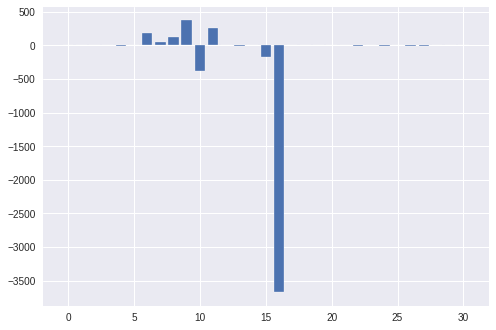

In [ ]:
# get importance
from matplotlib import pyplot
importance = lr.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

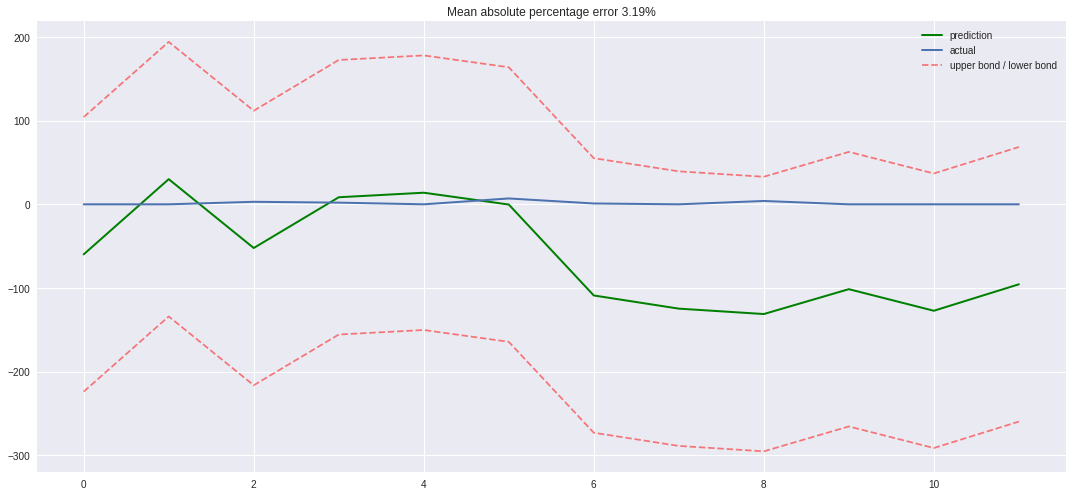

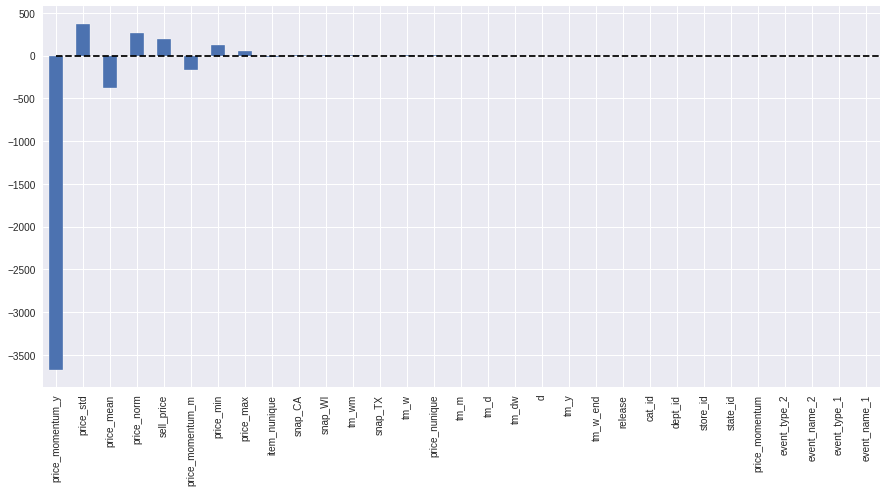

In [ ]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

### Code for Replacing Nan values and encoding categorical features

In [ ]:
# filla na and label encode categorical features
##def transform(data):
    
 ##   nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
 #   for feature in nan_features:
 #       data[feature].fillna('unknown', inplace = True)
        
  ##  cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 
   #        'event_name_2', 'event_type_2']
   # for feature in cat:
   ##     encoder = LabelEncoder()
   #     data[feature] = encoder.fit_transform(data[feature])